In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
# tf.random.set_seed(123)
# np.random.seed(123)
from sklearn import metrics
import json 
import os

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}',end='\n\n')
    return {'mse' : mse, 'mae' : mae, 'rmse' : rmse, 'mape' : mape, 'r2' : r2}
    
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

df = pd.read_csv(r'..\Data\Panama Electricity\continuous_dataset_preprocessing.csv', parse_dates= True)
df["datetime"] = df["datetime"].apply(pd.to_datetime)

column_names = df.columns.tolist()
train_column_names = df.columns.tolist()
column_names.remove('datetime')
train_column_names.remove('datetime')
train_column_names.remove('nat_demand')

In [2]:
valid = df[df['datetime'] <= '1/1/2019 23:00']
valid = valid[valid['datetime'] > '1/1/2018 23:00']
train = df[df['datetime'] <= '1/1/2018 23:00']
test = df[df['datetime'] > '1/1/2019 23:00']

# train['nat_demand'] = train['nat_demand'].clip(lower = 500)
# valid['nat_demand'] = valid['nat_demand'].clip(lower = 500)

x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
trainX = x_scaler.fit_transform(train[column_names])
trainY = y_scaler.fit_transform(train[['nat_demand']])
validX = x_scaler.fit_transform(valid[column_names])
validY = y_scaler.fit_transform(valid[['nat_demand']])

In [3]:
version = 1
# Version 1: Layer 1: 150 output, Layer 2: 50 outpu
# Version 2: dense: 0.4. But the result is not good compare to above model
# Version 3: Layer 1: 150 output, not exist Layer 2 

hist_window = 12 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

The new directory is created!
Epoch 1/150
100/100 [==============================] - 12s 64ms/step - loss: 0.1004 - val_loss: 0.0556
Epoch 2/150
100/100 [==============================] - 5s 53ms/step - loss: 0.0404 - val_loss: 0.0425
Epoch 3/150
100/100 [==============================] - 5s 51ms/step - loss: 0.0285 - val_loss: 0.0419
Epoch 4/150
100/100 [==============================] - 5s 54ms/step - loss: 0.0239 - val_loss: 0.0402
Epoch 5/150
100/100 [==============================] - 5s 50ms/step - loss: 0.0203 - val_loss: 0.0528
Epoch 6/150
100/100 [==============================] - 5s 49ms/step - loss: 0.0193 - val_loss: 0.0376
Epoch 7/150
100/100 [==============================] - 5s 53ms/step - loss: 0.0168 - val_loss: 0.0503
Epoch 8/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0167 - val_loss: 0.0390
Epoch 9/150
100/100 [==============================] - 5s 48ms/step - loss: 0.0147 - val_loss: 0.0364
Epoch 10/150
100/100 [=============================

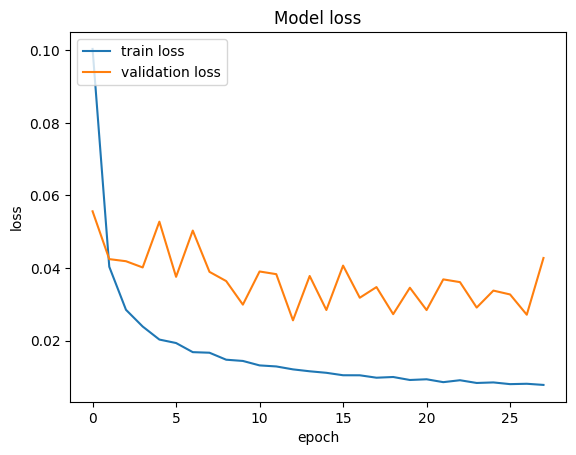

In [4]:
tf.keras.backend.clear_session()
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150), 
                               input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

folder_save = f"../Results/biLSTM/history_{hist_window}_future_{horizon}_version_{version}"
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(Bi_lstm_model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                         validation_data=val_data_multi, validation_steps=50, verbose=1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0, patience=15, 
                                                                     verbose=1, mode='min'), 
                                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                       save_best_only=True,
                                                                       mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'{folder_save}/history_loss.csv')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],
                                                  Predicted_results_Inv_trans[0])

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)

In [5]:
version = 1
# Version 1: Layer 1: 150 output, Layer 2: 50 outpu
# Version 2: dense: 0.4. But the result is not good compare to above model
# Version 3: Layer 1: 150 output, not exist Layer 2 

hist_window = 18 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

The new directory is created!
Epoch 1/150
100/100 [==============================] - 13s 79ms/step - loss: 0.0805 - val_loss: 0.0521
Epoch 2/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0366 - val_loss: 0.0412
Epoch 3/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0257 - val_loss: 0.0317
Epoch 4/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0221 - val_loss: 0.0331
Epoch 5/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0186 - val_loss: 0.0460
Epoch 6/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0172 - val_loss: 0.0423
Epoch 7/150
100/100 [==============================] - 7s 71ms/step - loss: 0.0150 - val_loss: 0.0307
Epoch 8/150
100/100 [==============================] - 7s 72ms/step - loss: 0.0143 - val_loss: 0.0354
Epoch 9/150
100/100 [==============================] - 7s 69ms/step - loss: 0.0130 - val_loss: 0.0449
Epoch 10/150
100/100 [=============================

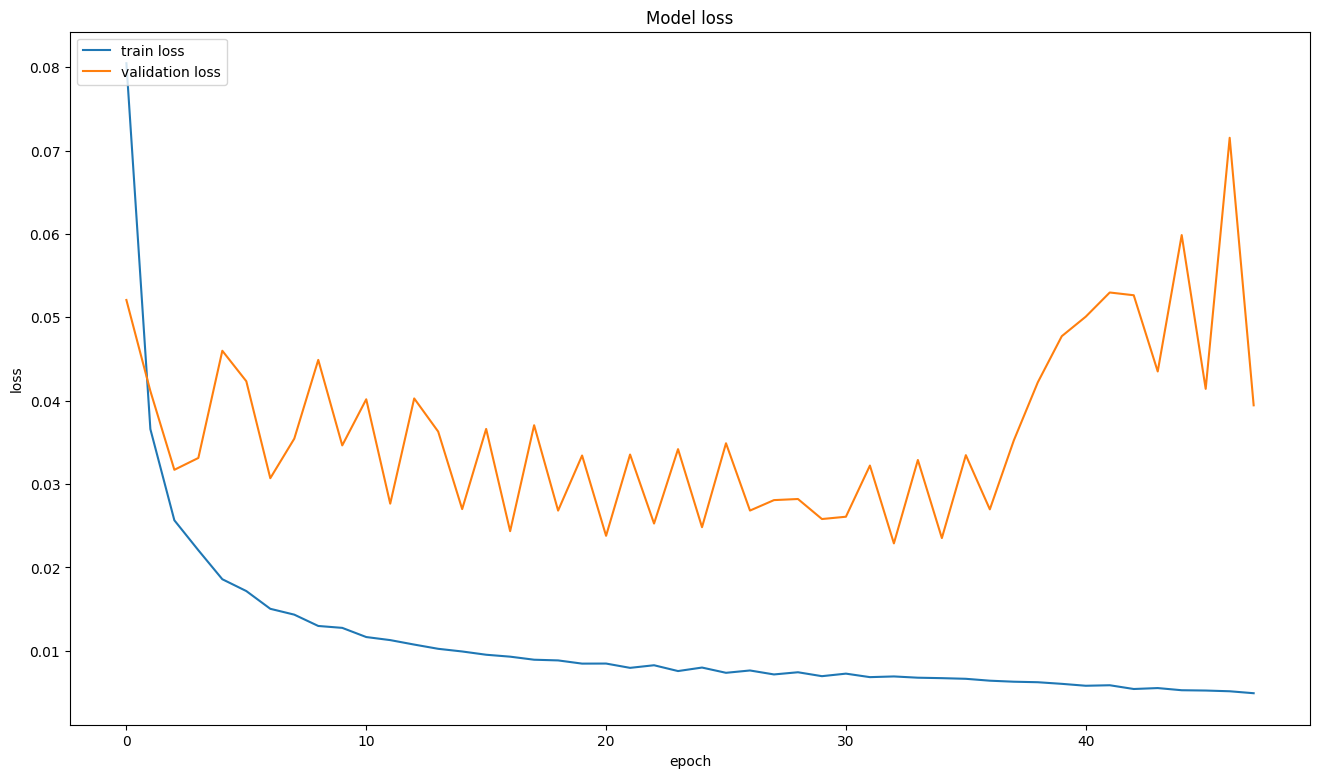

In [6]:
tf.keras.backend.clear_session()
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150), 
                               input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

folder_save = f"../Results/biLSTM/history_{hist_window}_future_{horizon}_version_{version}"
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(Bi_lstm_model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                         validation_data=val_data_multi, validation_steps=50, verbose=1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0, patience=15, 
                                                                     verbose=1, mode='min'), 
                                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                       save_best_only=True,
                                                                       mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'{folder_save}/history_loss.csv')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],
                                                  Predicted_results_Inv_trans[0])

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)

In [7]:
version = 1
# Version 1: Layer 1: 150 output, Layer 2: 50 outpu
# Version 2: dense: 0.4. But the result is not good compare to above model
# Version 3: Layer 1: 150 output, not exist Layer 2 

hist_window = 30 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

The new directory is created!
Epoch 1/150
100/100 [==============================] - 17s 120ms/step - loss: 0.0908 - val_loss: 0.0455
Epoch 2/150
100/100 [==============================] - 12s 118ms/step - loss: 0.0367 - val_loss: 0.0382
Epoch 3/150
100/100 [==============================] - 12s 120ms/step - loss: 0.0256 - val_loss: 0.0341
Epoch 4/150
100/100 [==============================] - 12s 121ms/step - loss: 0.0227 - val_loss: 0.0418
Epoch 5/150
100/100 [==============================] - 12s 120ms/step - loss: 0.0189 - val_loss: 0.0535
Epoch 6/150
100/100 [==============================] - 12s 125ms/step - loss: 0.0173 - val_loss: 0.0473
Epoch 7/150
100/100 [==============================] - 12s 124ms/step - loss: 0.0154 - val_loss: 0.0354
Epoch 8/150
100/100 [==============================] - 12s 120ms/step - loss: 0.0146 - val_loss: 0.0434
Epoch 9/150
100/100 [==============================] - 12s 118ms/step - loss: 0.0132 - val_loss: 0.0459
Epoch 10/150
100/100 [============

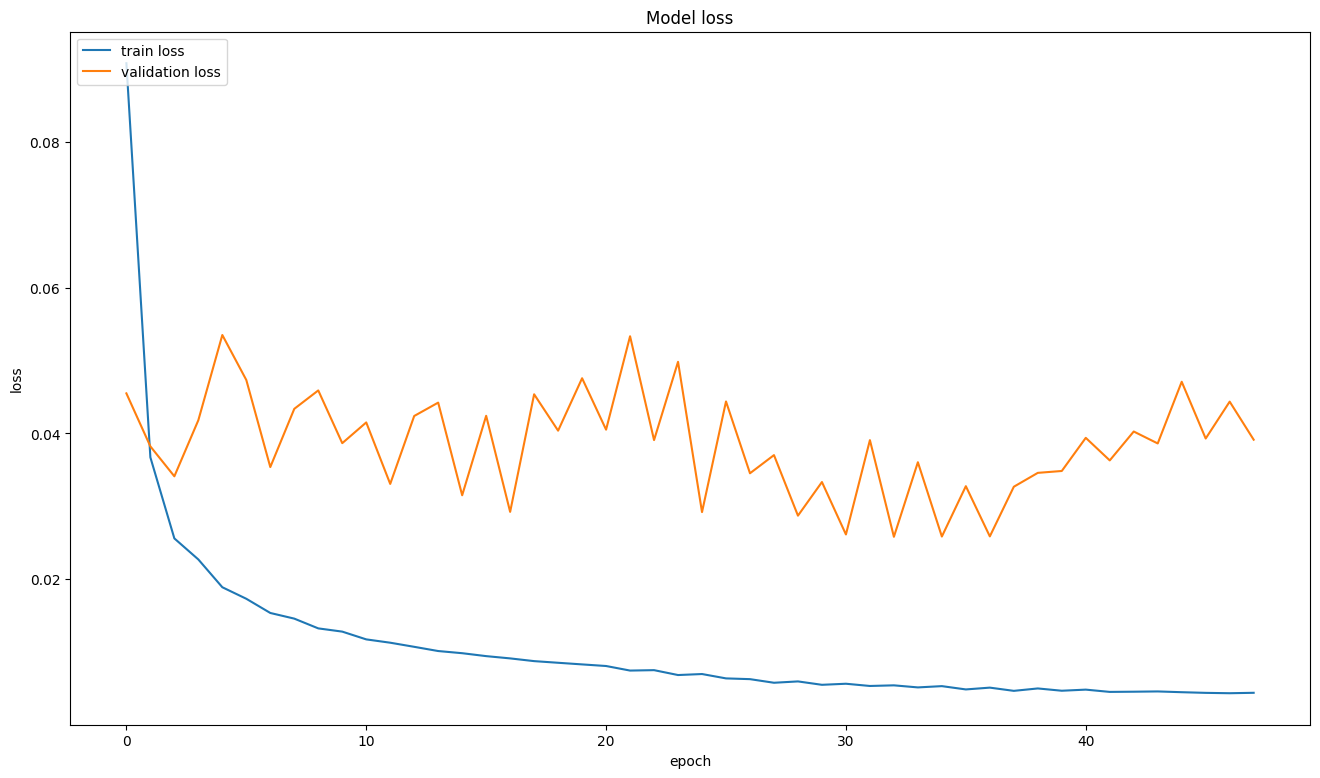

In [8]:
tf.keras.backend.clear_session()
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150), 
                               input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

folder_save = f"../Results/biLSTM/history_{hist_window}_future_{horizon}_version_{version}"
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(Bi_lstm_model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                         validation_data=val_data_multi, validation_steps=50, verbose=1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0, patience=15, 
                                                                     verbose=1, mode='min'), 
                                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                       save_best_only=True,
                                                                       mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'{folder_save}/history_loss.csv')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],
                                                  Predicted_results_Inv_trans[0])

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)

In [9]:
version = 1
# Version 1: Layer 1: 150 output, Layer 2: 50 outpu
# Version 2: dense: 0.4. But the result is not good compare to above model
# Version 3: Layer 1: 150 output, not exist Layer 2 

hist_window = 36 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

The new directory is created!
Epoch 1/150
100/100 [==============================] - 22s 174ms/step - loss: 0.0925 - val_loss: 0.0523
Epoch 2/150
100/100 [==============================] - 15s 152ms/step - loss: 0.0379 - val_loss: 0.0442
Epoch 3/150
100/100 [==============================] - 15s 152ms/step - loss: 0.0267 - val_loss: 0.0336
Epoch 4/150
100/100 [==============================] - 15s 153ms/step - loss: 0.0228 - val_loss: 0.0429
Epoch 5/150
100/100 [==============================] - 15s 152ms/step - loss: 0.0191 - val_loss: 0.0502
Epoch 6/150
100/100 [==============================] - 15s 151ms/step - loss: 0.0172 - val_loss: 0.0477
Epoch 7/150
100/100 [==============================] - 15s 152ms/step - loss: 0.0153 - val_loss: 0.0336
Epoch 8/150
100/100 [==============================] - 15s 152ms/step - loss: 0.0147 - val_loss: 0.0425
Epoch 9/150
100/100 [==============================] - 15s 151ms/step - loss: 0.0134 - val_loss: 0.0476
Epoch 10/150
100/100 [============

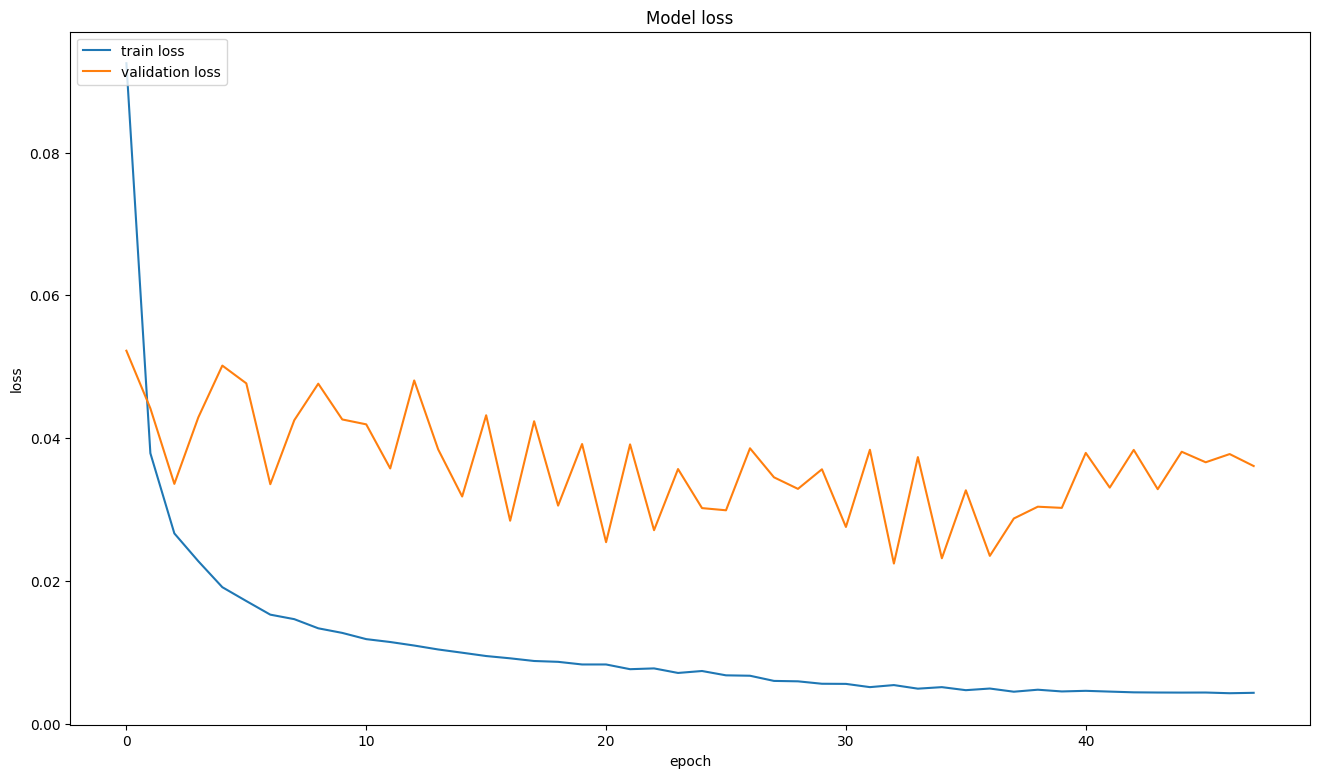

In [10]:
tf.keras.backend.clear_session()
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150), 
                               input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

folder_save = f"../Results/biLSTM/history_{hist_window}_future_{horizon}_version_{version}"
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(Bi_lstm_model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                         validation_data=val_data_multi, validation_steps=50, verbose=1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0, patience=15, 
                                                                     verbose=1, mode='min'), 
                                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                       save_best_only=True,
                                                                       mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'{folder_save}/history_loss.csv')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],
                                                  Predicted_results_Inv_trans[0])

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)

In [11]:
version = 1
# Version 1: Layer 1: 150 output, Layer 2: 50 outpu
# Version 2: dense: 0.4. But the result is not good compare to above model
# Version 3: Layer 1: 150 output, not exist Layer 2 

hist_window = 42 # 12, 18, 24, 30, 36, 42
horizon = 24 # 12, 18, 24, 30, 36

x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    trainX, trainY, 0, None, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    validX, validY, 0, None, hist_window, horizon)

BATCH_SIZE = 128
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

The new directory is created!
Epoch 1/150
100/100 [==============================] - 28s 233ms/step - loss: 0.1046 - val_loss: 0.0511
Epoch 2/150
100/100 [==============================] - 23s 230ms/step - loss: 0.0401 - val_loss: 0.0417
Epoch 3/150
100/100 [==============================] - 24s 240ms/step - loss: 0.0274 - val_loss: 0.0306
Epoch 4/150
100/100 [==============================] - 24s 239ms/step - loss: 0.0229 - val_loss: 0.0395
Epoch 5/150
100/100 [==============================] - 24s 241ms/step - loss: 0.0190 - val_loss: 0.0551
Epoch 6/150
100/100 [==============================] - 24s 238ms/step - loss: 0.0172 - val_loss: 0.0480
Epoch 7/150
100/100 [==============================] - 24s 240ms/step - loss: 0.0154 - val_loss: 0.0347
Epoch 8/150
100/100 [==============================] - 24s 237ms/step - loss: 0.0145 - val_loss: 0.0393
Epoch 9/150
100/100 [==============================] - 24s 238ms/step - loss: 0.0132 - val_loss: 0.0464
Epoch 10/150
100/100 [============

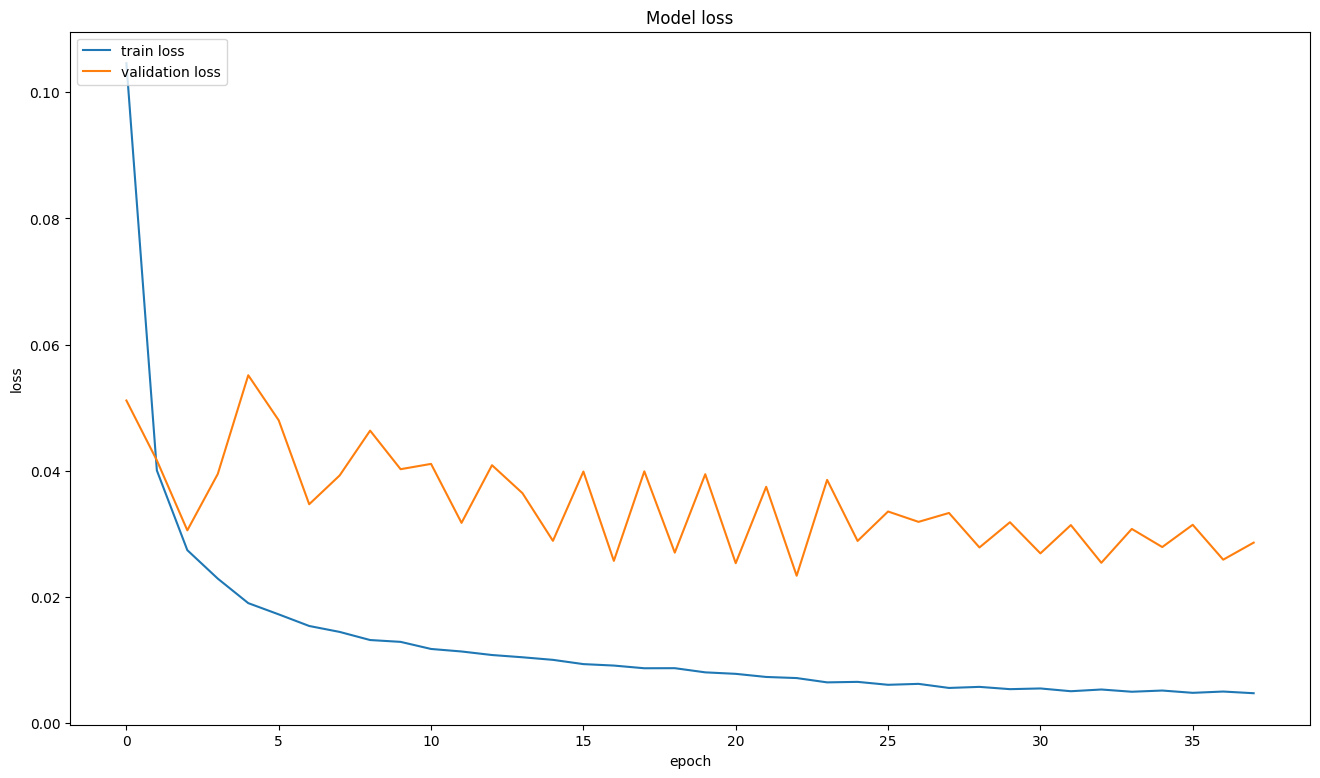

In [12]:
tf.keras.backend.clear_session()
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150), 
                               input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

folder_save = f"../Results/biLSTM/history_{hist_window}_future_{horizon}_version_{version}"
isExist = os.path.exists(folder_save)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(folder_save)
   print("The new directory is created!")

model_path = f'{folder_save}/model.h5' 

with open(f"{folder_save}/model_config.json", "w") as outfile:
    json.dump(Bi_lstm_model.get_config(), outfile)

EVALUATION_INTERVAL = 100
EPOCHS = 150
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, 
                         validation_data=val_data_multi, validation_steps=50, verbose=1,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                     min_delta=0, patience=15, 
                                                                     verbose=1, mode='min'), 
                                    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', 
                                                                       save_best_only=True,
                                                                       mode='min', verbose=0)])

Trained_model = tf.keras.models.load_model(model_path)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.savefig(f'{folder_save}/history_loss.pdf', bbox_inches='tight')
plt.savefig(f'{folder_save}/history_loss.svg', bbox_inches='tight')
history_loss = [list(a) for a in zip(history.history['loss'], history.history['val_loss'])]
df_loss = pd.DataFrame(history_loss, columns =['loss', 'val_loss']) 
df_loss.to_csv(f'{folder_save}/history_loss.csv')

data_test = x_scaler.fit_transform(valid[column_names].tail(hist_window))
test_rescaled = data_test.reshape(1, data_test.shape[0], data_test.shape[1])

Predicted_results = Trained_model.predict(test_rescaled)
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)
metrics_test = timeseries_evaluation_metrics_func(test['nat_demand'][:horizon],
                                                  Predicted_results_Inv_trans[0])

with open(f"{folder_save}/metrics_test.json", "w") as outfile:
    json.dump(metrics_test, outfile)